In [236]:
# "Why, when, and how variability in emotion expression makes people look authentic and leader-like"
# Analysis script for Study 3
# Evan W. Carr, 05-01-2018 (Columbia Business School)

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.mediation as smm

from plotnine import *
from rpy2.robjects import r, pandas2ri

%matplotlib inline  

# Set working directory to location of data files, and read in .csv's:
rawData = pd.read_csv('amanic3_exptrun_final_clean_17_11_30.csv')
rawDemog = pd.read_csv('demographics_survey_survey_17_11_30.csv')
rawJobs = pd.read_csv('job_survey_survey_17_11_30.csv')

rawData.head(20)

,date,time,group,subject,build,blocknum,trialnum,blockcode,trialcode,pretrialpause,...,latency,stimulusnumber1,stimulusitem1,stimulusonset1,stimulusnumber2,stimulusitem2,stimulusonset2,stimulusnumber3,stimulusitem3,stimulusonset3
0,113017,05:49:20,336745360,102141329,5.0.10.0,1,1,expt_intro,expt_intro,0,...,8696,1,"Welcome to the study! During this session, ...",5,1,cbs_logo.jpg,5,1,"If you need to exit the study early, you can d...",5
1,113017,05:49:20,336745360,102141329,5.0.10.0,2,1,lv1_male_block,lv1_male_trial,0,...,500,133,WM-029_-04_crop.jpg,0,0,0,0,0,0,0
2,113017,05:49:20,336745360,102141329,5.0.10.0,2,2,lv1_male_block,lv1_male_trial,0,...,500,124,WM-029_-03_crop.jpg,0,0,0,0,0,0,0
3,113017,05:49:20,336745360,102141329,5.0.10.0,2,3,lv1_male_block,lv1_male_trial,0,...,500,143,WM-029_-04_crop.jpg,0,0,0,0,0,0,0
4,113017,05:49:20,336745360,102141329,5.0.10.0,2,4,lv1_male_block,lv1_male_trial,0,...,500,141,WM-029_-06_crop.jpg,0,0,0,0,0,0,0
5,113017,05:49:20,336745360,102141329,5.0.10.0,2,5,lv1_male_block,lv1_male_trial,0,...,500,148,WM-029_04_crop.jpg,0,0,0,0,0,0,0
6,113017,05:49:20,336745360,102141329,5.0.10.0,2,6,lv1_male_block,lv1_male_trial,0,...,500,122,WM-029_-05_crop.jpg,0,0,0,0,0,0,0
7,113017,05:49:20,336745360,102141329,5.0.10.0,2,7,lv1_male_block,lv1_male_trial,0,...,500,130,WM-029_06_crop.jpg,0,0,0,0,0,0,0
8,113017,05:49:20,336745360,102141329,5.0.10.0,2,8,lv1_male_block,lv1_male_trial,0,...,500,142,WM-029_-05_crop.jpg,0,0,0,0,0,0,0
9,113017,05:49:20,336745360,102141329,5.0.10.0,2,9,lv1_male_block,lv1_male_trial,0,...,500,121,WM-029_-06_crop.jpg,0,0,0,0,0,0,0


In [237]:
# All subjects should have 458 observations (rows) in the dataset ...
# Any that have more/less than 458 need to be removed before analysis:
rawObsCount = (rawData
               .groupby('subject', as_index=False)
               .size()
               .reset_index(name='counts')
               .sort_values(by='counts'))

rawObsCount.head(40)

,subject,counts
112,474822642,12
125,532063191,17
113,484746718,21
82,329502311,37
232,994211854,37
99,399120862,37
14,45797134,37
98,398685616,37
166,715551666,37
78,317152610,37


In [238]:
# Create list of subject ID's to exclude:
exclSbj = rawObsCount.query('counts != 458')
exclSbj = np.array(exclSbj['subject'])
exclSbj

array([474822642, 532063191, 484746718, 329502311, 994211854, 399120862,
        45797134, 398685616, 715551666, 317152610, 961290475, 621169369,
       465249040, 932904243, 942818513, 147055104, 198741392, 819540818,
       533213513, 904746232, 650345568,  11432141, 102686385, 991603667,
       417262918, 346153982,  81733899, 492883120,  76819037, 521944326], dtype=int64)

In [239]:
# Filter to important columns, and exclude subjects that didn't finish the study:
cleanCols = ['subject', 'blocknum', 'trialnum', 'blockcode', 'trialcode', 'response', 'latency', 'stimulusitem1']
cleanData = rawData.loc[~rawData['subject'].isin(exclSbj), cleanCols]
cleanData.head()

,subject,blocknum,trialnum,blockcode,trialcode,response,latency,stimulusitem1
0,102141329,1,1,expt_intro,expt_intro,57.0,8696,"Welcome to the study! During this session, ..."
1,102141329,2,1,lv1_male_block,lv1_male_trial,0.0,500,WM-029_-04_crop.jpg
2,102141329,2,2,lv1_male_block,lv1_male_trial,0.0,500,WM-029_-03_crop.jpg
3,102141329,2,3,lv1_male_block,lv1_male_trial,0.0,500,WM-029_-04_crop.jpg
4,102141329,2,4,lv1_male_block,lv1_male_trial,0.0,500,WM-029_-06_crop.jpg


In [240]:
# Get quick demographics summary, without excluded subjects:
demogSummary = (rawDemog
                .groupby('subject')
                .agg({'age_response': np.mean, "gender_response": pd.Series.unique})
                .reset_index())

demogSummary = demogSummary[~demogSummary['subject'].isin(exclSbj)]

demogSummary['age_response'].mean()

34.31730769230769

In [241]:
demogSummary['age_response'].std()

9.245199222217513

In [242]:
demogSummary['gender_response'].value_counts()

Female    115
Male       93
Name: gender_response, dtype: int64

In [243]:
# Take a look at the data from the job survey.  Questions asked included ...
#    - Currently employed? (y/n) -- if so, how many years?
#    - Managerial status? (top, middle, lower, non)
#    - Job industry

cleanJobs = rawJobs[['subject', 
                     'currently_employed_response', 
                     'years_at_job_response',
                     'mgr_status_response',
                     'industry_type_response']]

cleanJobs.head(20)

,subject,currently_employed_response,years_at_job_response,mgr_status_response,industry_type_response
0,102141329,Yes,8,lower-management,Government
1,979861234,Yes,2,non-management,Construction
2,249446064,Yes,1,non-management,High Tech
3,624134831,Yes,17,middle-management,Finance
4,920783273,Yes,2,lower-management,Manufacturing
5,70403218,Yes,2,non-management,Service
6,398606346,Yes,4,lower-management,Educational
7,539316507,Yes,5,non-management,Medical
8,179849058,Yes,4,top-management,Finance
9,216039920,Yes,5,non-management,Non-profit


In [244]:
# Are most of the subjects currently employed?  (Yes, ~99% have a job)
100 * (len(cleanJobs.loc[cleanJobs['currently_employed_response']=='Yes']) / cleanJobs.shape[0])

98.5781990521327

In [245]:
# Of the subjects that are currently employed, how long have they been at their jobs, by management type?
# (average range between 4-13 years across levels, with lots of variability for top-management)
(cleanJobs.loc[cleanJobs['currently_employed_response']=='Yes']
 .groupby('mgr_status_response')
 .agg({'years_at_job_response': [np.mean, np.std]})
 .reset_index())

mgr_status_response years_at_job_response           
                                       mean        std
0    lower-management              5.100000   4.307418
1   middle-management              6.807018   5.138922
2      non-management              4.687500   5.595699
3      top-management             12.733333  21.818952

In [246]:
# What percentages of our subjects fall into which industries, and how many years have they been there?
# (Many subjects work in service, education, and/or high-tech -- all > 10% of our subject pool, 
# and all industry types have average number of years > 3)
industryPerc = (100 * (cleanJobs.loc[cleanJobs['currently_employed_response']=='Yes', 'industry_type_response']
                      .value_counts() \
                      / cleanJobs.loc[cleanJobs['currently_employed_response']=='Yes', 'industry_type_response'].shape[0])
                .to_frame()).reset_index().rename(index=str, columns={'industry_type_response': 'percent_of_sbj'})

industryYrs = (cleanJobs.loc[cleanJobs['currently_employed_response']=='Yes']
               .groupby('industry_type_response')
               .agg({'years_at_job_response': np.mean})
               .reset_index()
               .rename(index=str, columns={'industry_type_response': 'index', 'years_at_job_response': 'mean_yrs'}))

industryPerc.merge(industryYrs, on='index', how='inner')

,index,percent_of_sbj,mean_yrs
0,Service,14.903846,5.935484
1,Educational,12.019231,4.400000
2,High Tech,10.576923,5.818182
3,Medical,8.653846,9.222222
4,Consumer Goods,8.173077,6.176471
5,Government,7.692308,6.125000
6,Finance,7.211538,6.466667
7,Manufacturing,6.250000,6.076923
8,Non-profit,5.288462,5.000000
9,Construction,4.326923,4.222222


In [247]:
# Create column for emotion variability condition ('model_block'):
cleanData = (cleanData
             .join(cleanData['blockcode'].str.split('_', 1, expand=True)
                   .rename(columns={0:'model_block', 1:'junk'})))

cleanData = cleanData.drop(['junk'], axis=1)

cleanData.head()

,subject,blocknum,trialnum,blockcode,trialcode,response,latency,stimulusitem1,model_block
0,102141329,1,1,expt_intro,expt_intro,57.0,8696,"Welcome to the study! During this session, ...",expt
1,102141329,2,1,lv1_male_block,lv1_male_trial,0.0,500,WM-029_-04_crop.jpg,lv1
2,102141329,2,2,lv1_male_block,lv1_male_trial,0.0,500,WM-029_-03_crop.jpg,lv1
3,102141329,2,3,lv1_male_block,lv1_male_trial,0.0,500,WM-029_-04_crop.jpg,lv1
4,102141329,2,4,lv1_male_block,lv1_male_trial,0.0,500,WM-029_-06_crop.jpg,lv1


In [248]:
# Map emotion variability condition ('model_block') to umbrella factor: 
varDict = {
    'expt': 'expt',
    'lv1': 'lv',
    'lv2': 'lv',
    'lv3': 'lv',
    'hv1': 'hv',
    'hv2': 'hv',
    'hv3': 'hv'
}

cleanData['model_block'] = cleanData['model_block'].map(varDict)

# Need to also map types of slider questions to new factor:
trialcodeSplit = lambda x: x.str.split('_', 3, expand=True)
    
cleanData['overallDim'] = trialcodeSplit(cleanData['trialcode'])[0]
cleanData['specificDim'] = trialcodeSplit(cleanData['trialcode'])[1]

cleanData.loc[cleanData['trialcode']=='power_overall_slider', 'specificDim'] = 'power'
cleanData.loc[cleanData['trialcode']=='authenticity_overall_slider', 'specificDim'] = 'authenticity'

cleanData.head(40)

,subject,blocknum,trialnum,blockcode,trialcode,response,latency,stimulusitem1,model_block,overallDim,specificDim
0,102141329,1,1,expt_intro,expt_intro,57.0,8696,"Welcome to the study! During this session, ...",expt,expt,intro
1,102141329,2,1,lv1_male_block,lv1_male_trial,0.0,500,WM-029_-04_crop.jpg,lv,lv1,male
2,102141329,2,2,lv1_male_block,lv1_male_trial,0.0,500,WM-029_-03_crop.jpg,lv,lv1,male
3,102141329,2,3,lv1_male_block,lv1_male_trial,0.0,500,WM-029_-04_crop.jpg,lv,lv1,male
4,102141329,2,4,lv1_male_block,lv1_male_trial,0.0,500,WM-029_-06_crop.jpg,lv,lv1,male
5,102141329,2,5,lv1_male_block,lv1_male_trial,0.0,500,WM-029_04_crop.jpg,lv,lv1,male
6,102141329,2,6,lv1_male_block,lv1_male_trial,0.0,500,WM-029_-05_crop.jpg,lv,lv1,male
7,102141329,2,7,lv1_male_block,lv1_male_trial,0.0,500,WM-029_06_crop.jpg,lv,lv1,male
8,102141329,2,8,lv1_male_block,lv1_male_trial,0.0,500,WM-029_-05_crop.jpg,lv,lv1,male
9,102141329,2,9,lv1_male_block,lv1_male_trial,0.0,500,WM-029_-06_crop.jpg,lv,lv1,male


In [249]:
# Access and log stimulus model ID codes for inclusion in mixed-effects models (shown later):
ratingsList = ['authenticity', 'power', 'inhibition', 'activation']
modelSummary = (cleanData
                .groupby(['subject', 'blocknum'])
                .agg({"stimulusitem1": pd.Series.unique})
                .reset_index())

modelSummary.head(10)

,subject,blocknum,stimulusitem1
0,48008,1,"Welcome to the study! During this session, ..."
1,48008,2,"[WF-016_03.jpg, WF-016_-04.jpg, WF-016_04.jpg,..."
2,48008,3,"[WM-003_04_crop.jpg, WM-003_05_crop.jpg, WM-00..."
3,48008,4,"[WM-006_-02_crop.jpg, WM-006_05_crop.jpg, WM-0..."
4,48008,5,"[WF-027_08.jpg, WF-027_-03.jpg, WF-027_-06.jpg..."
5,48008,6,"[WF-015_03.jpg, WF-015_-06.jpg, WF-015_-04.jpg..."
6,48008,7,"[WF-011_-10.jpg, WF-011_16.jpg, WF-011_-15.jpg..."
7,48008,8,"[WM-009_02_crop.jpg, WM-009_04_crop.jpg, WM-00..."
8,48008,9,"[WF-003_02.jpg, WF-003_05.jpg, WF-003_-12.jpg,..."
9,48008,10,"[WM-033_05_crop.jpg, WM-033_02_crop.jpg, WM-03..."


In [250]:
# 'modelSummary' dataframe shows all unique stimuli shown to each subject, by blocknum ...
# Not useful yet, but will be if we can split stimulus names apart:
modelList = []
for i in range(0, modelSummary.shape[0]):
    modelID = modelSummary.iloc[i]['stimulusitem1'][0].split('_', 1)[0]
    modelList.append(modelID)
    
modelSummary['model_id'] = modelList
modelSummary = modelSummary.drop('stimulusitem1', axis=1)

modelSummary.head(15)

,subject,blocknum,model_id
0,48008,1,W
1,48008,2,WF-016
2,48008,3,WM-003
3,48008,4,WM-006
4,48008,5,WF-027
5,48008,6,WF-015
6,48008,7,WF-011
7,48008,8,WM-009
8,48008,9,WF-003
9,48008,10,WM-033


In [251]:
# Subjects only saw real stimuli in blocknum's 2-13 ...
# Do an inner join with the main data to get only those blocks, then filter to only when subjects gave ratings:
cleanRatings = pd.merge(cleanData, modelSummary, on=('subject', 'blocknum'), how='inner')
cleanRatings = cleanRatings.loc[(cleanRatings['model_block'] != 'expt') & (cleanRatings['overallDim'].isin(ratingsList)), :]
cleanRatings = cleanRatings.drop(['blocknum', 'trialnum', 'blockcode', 'trialcode', 'stimulusitem1'], axis=1)

cleanRatings.head(40)

,subject,response,latency,model_block,overallDim,specificDim,model_id
31,102141329,57.0,24246,lv,inhibition,openminded,WM-029
32,102141329,64.0,24246,lv,inhibition,truefeelings,WM-029
33,102141329,73.0,24246,lv,inhibition,truethoughts,WM-029
34,102141329,83.0,24246,lv,activation,takeaction,WM-029
35,102141329,47.0,24246,lv,activation,thinkquick,WM-029
36,102141329,45.0,24246,lv,activation,authoritative,WM-029
37,102141329,58.0,6513,lv,power,power,WM-029
38,102141329,60.0,3190,lv,authenticity,authenticity,WM-029
69,102141329,84.0,21603,lv,inhibition,openminded,WM-009
70,102141329,79.0,21603,lv,inhibition,truefeelings,WM-009


In [252]:
# Generate wide version of dataframe for later mediation analyses:
cleanRatings_wide = (cleanRatings
                     .drop(['latency', 'overallDim'], axis=1)
                     .set_index(['subject', 'model_block', 'model_id', 'specificDim'])
                     .unstack('specificDim')
                     .reset_index())

def flatten_cols(df):
    df.columns = ['_'.join(tuple(map(str, t))).rstrip('_') for t in df.columns.values]
    return df

cleanRatings_wide = flatten_cols(cleanRatings_wide)

cleanRatings_wide['index_inhibition'] = cleanRatings_wide.loc[:, ['response_openminded',
                                                                  'response_truefeelings',
                                                                  'response_truethoughts']].mean(axis=1)
cleanRatings_wide['index_activation'] = cleanRatings_wide.loc[:, ['response_authoritative',
                                                                  'response_takeaction',
                                                                  'response_thinkquick']].mean(axis=1)

cleanRatings_wide.head(20)

,subject,model_block,model_id,response_authenticity,response_authoritative,response_openminded,response_power,response_takeaction,response_thinkquick,response_truefeelings,response_truethoughts,index_inhibition,index_activation
0,48008,hv,WF-003,87.0,34.0,81.0,37.0,58.0,63.0,76.0,88.0,81.666667,51.666667
1,48008,hv,WF-011,78.0,27.0,42.0,60.0,41.0,43.0,42.0,39.0,41.000000,37.000000
2,48008,hv,WF-027,87.0,42.0,60.0,66.0,55.0,62.0,69.0,65.0,64.666667,53.000000
3,48008,hv,WM-016,29.0,84.0,32.0,53.0,56.0,40.0,66.0,72.0,56.666667,60.000000
4,48008,hv,WM-029,93.0,22.0,74.0,31.0,38.0,19.0,40.0,39.0,51.000000,26.333333
5,48008,hv,WM-033,63.0,46.0,69.0,37.0,37.0,41.0,38.0,36.0,47.666667,41.333333
6,48008,lv,WF-009,92.0,24.0,89.0,56.0,37.0,38.0,18.0,15.0,40.666667,33.000000
7,48008,lv,WF-015,95.0,57.0,56.0,75.0,55.0,55.0,68.0,70.0,64.666667,55.666667
8,48008,lv,WF-016,44.0,87.0,32.0,53.0,59.0,60.0,91.0,87.0,70.000000,68.666667
9,48008,lv,WM-003,27.0,91.0,9.0,41.0,58.0,76.0,81.0,84.0,58.000000,75.000000


In [253]:
# Create individual datasets for each major DV:
authenticityData = cleanRatings.query("specificDim == 'authenticity'")
powerData = cleanRatings.query("specificDim == 'power'")

In [254]:
# Generate quick correlation tables, split out by variability condition: 
specDimMat = (cleanRatings
              .groupby(['subject', 'model_block', 'specificDim'])
              .agg({'response': np.mean})
              .reset_index())

specDimMat_hv = specDimMat.query("model_block == 'hv'").pivot(index='subject', columns='specificDim', values='response')
specDimMat_lv = specDimMat.query("model_block == 'lv'").pivot(index='subject', columns='specificDim', values='response')

specDimMat_hv.corr()

specificDim,authenticity,authoritative,openminded,power,takeaction,thinkquick,truefeelings,truethoughts
specificDim,,,,,,,,
authenticity,1.000000,0.364274,0.447831,0.514005,0.577753,0.506427,0.423380,0.378435
authoritative,0.364274,1.000000,0.025673,0.658613,0.611381,0.568262,0.351821,0.386854
openminded,0.447831,0.025673,1.000000,0.213034,0.218010,0.281587,0.132097,0.134599
power,0.514005,0.658613,0.213034,1.000000,0.602983,0.587151,0.427462,0.435331
takeaction,0.577753,0.611381,0.218010,0.602983,1.000000,0.653436,0.438821,0.424774
thinkquick,0.506427,0.568262,0.281587,0.587151,0.653436,1.000000,0.371758,0.288275
truefeelings,0.423380,0.351821,0.132097,0.427462,0.438821,0.371758,1.000000,0.822032
truethoughts,0.378435,0.386854,0.134599,0.435331,0.424774,0.288275,0.822032,1.000000


In [255]:
specDimMat_lv.corr()

specificDim,authenticity,authoritative,openminded,power,takeaction,thinkquick,truefeelings,truethoughts
specificDim,,,,,,,,
authenticity,1.000000,0.388502,0.614373,0.508198,0.492506,0.493270,0.489476,0.507781
authoritative,0.388502,1.000000,0.194991,0.806009,0.819994,0.727259,0.272366,0.246633
openminded,0.614373,0.194991,1.000000,0.331302,0.333542,0.416609,0.390092,0.402637
power,0.508198,0.806009,0.331302,1.000000,0.762565,0.734050,0.314648,0.284571
takeaction,0.492506,0.819994,0.333542,0.762565,1.000000,0.818267,0.360495,0.376131
thinkquick,0.493270,0.727259,0.416609,0.734050,0.818267,1.000000,0.303519,0.336476
truefeelings,0.489476,0.272366,0.390092,0.314648,0.360495,0.303519,1.000000,0.787208
truethoughts,0.507781,0.246633,0.402637,0.284571,0.376131,0.336476,0.787208,1.000000


In [256]:
# Run mixed-effects models on each DV in R:
#    - fixed = variability (high vs. low)
#    - random = subject & model_id

# Push objects to R (statsmodels package in python has trouble fitting certain random-effect structures):

pandas2ri.activate()
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [257]:
# Send datasets with ratings to R: 
%R -i cleanRatings_wide,authenticityData,powerData

In [258]:
%%R

# Use R to create mixed-effects models with both subject- and stimulus-level random effects:

library(lmerTest)

authenticity_m1 <- lmer(response ~ model_block + (1|subject) + (1|model_id), data=authenticityData)
authenticity_m1_anova <- anova(authenticity_m1)
authenticity_m1_lsmeans <- lsmeans(authenticity_m1)
             
power_m1 <- lmer(response ~ model_block + (1|subject) + (1|model_id), data=powerData)
power_m1_anova <- anova(power_m1)
power_m1_lsmeans <- lsmeans(power_m1)

# Include rating type ('overallDim' = authenticity vs. power) as another factor for overall ratings analysis:
both_m1 <- lmer(response ~ model_block * overallDim 
                + (1|subject) + (1|model_id), data=rbind(authenticityData, powerData))
both_m1_anova <- anova(both_m1)
both_m1_lsmeans <- lsmeans(both_m1)

# Need to figure out which subdimensions are most affected by changes in emotion variability ...
# Build separate models where activation/inhibition ~ variability (controlling for other index):
activation_m1 <- lmer(index_activation ~ model_block + index_inhibition 
                      + (1|subject) + (1|model_id), data=cleanRatings_wide)
activation_m1_summary <- as.data.frame(summary(activation_m1)$coefficients)

inhibition_m1 <- lmer(index_inhibition ~ model_block + index_activation 
                      + (1|subject) + (1|model_id), data=cleanRatings_wide)
inhibition_m1_summary <- as.data.frame(summary(inhibition_m1)$coefficients)

# Also want to predict overall dimensions of authenticity vs. power by indices ...
# Build separate models where authenticity/power ~ activation vs. inhibition indices (controlling for variability):
authenticity_m2 <- lmer(response_authenticity ~ model_block 
                        + index_inhibition + index_activation
                        + (1|subject) + (1|model_id), data=cleanRatings_wide)
authenticity_m2_summary <- as.data.frame(summary(authenticity_m2)$coefficients)

power_m2 <- lmer(response_power ~ model_block
                 + index_inhibition + index_activation
                 + (1|subject) + (1|model_id), data=cleanRatings_wide)
power_m2_summary <- as.data.frame(summary(power_m2)$coefficients)

In [259]:
# Pull model results back to python:
%R -o authenticity_m1_anova,authenticity_m1_lsmeans,power_m1_anova,power_m1_lsmeans,both_m1_anova,both_m1_lsmeans
%R -o activation_m1_summary,inhibition_m1_summary,authenticity_m2_summary,power_m2_summary

In [260]:
pandas2ri.ri2py(authenticity_m1_anova)

,Sum Sq,Mean Sq,NumDF,DenDF,F.value,Pr(>F)
model_block,24803.011215,24803.011215,1,2277.342856,58.925218,2.398082e-14


In [261]:
pandas2ri.ri2py(power_m1_anova)

,Sum Sq,Mean Sq,NumDF,DenDF,F.value,Pr(>F)
model_block,9906.185346,9906.185346,1,2276.850282,24.781,6.904123e-07


In [262]:
pandas2ri.ri2py(both_m1_anova)

,Sum Sq,Mean Sq,NumDF,DenDF,F.value,Pr(>F)
model_block,32997.142572,32997.142572,1,4771.894631,77.769445,0.000000
overallDim,8949.490385,8949.490385,1,4769.904437,21.092642,0.000004
model_block:overallDim,2229.346154,2229.346154,1,4769.904437,5.254243,0.021937


In [263]:
# High-variability leads to greater ratings of authenticity and power, but the effect is
# stronger for authenticity (interaction in combined model) ...

# Evaluate 1st group of models, where each index (activation vs. inhibition) 
# is predicted by variability (controlling for alternative index):

modelSummary1 = pd.concat([activation_m1_summary.loc[['model_blocklv'], :].rename({'model_blocklv': 'activation'}),
                           inhibition_m1_summary.loc[['model_blocklv'], :].rename({'model_blocklv': 'inhibition'})],
                          axis=0)

modelSummary1

,Estimate,Std. Error,df,t value,Pr(>|t|)
activation,-1.843985,0.682829,2288.894836,-2.700506,6.974409e-03
inhibition,-5.020623,0.629534,2282.241952,-7.975140,2.220446e-15


In [264]:
# Variability was a stronger predictor of disinhibition than activation ...
# Supports and extends Study 2 findings, where variability was most closely associated 
# with increased perceptions of genuineness and openness (which, in turn, led to more 
# favorable impressions of authenticity). This also reveals that increased authenticity 
# from high-variability impacts leadership perceptions, making someone in a leadership 
# role appear more uninhibited (rather than more prone to action).

# Look at results from 2nd group of models, where the overarching dimensions (authenticity or power)
# are predicted by each of the individual activation/inhibition indices (controlling for variability):

authenticity_m2_stats = (authenticity_m2_summary
                         .drop(['(Intercept)', 'model_blocklv'], axis=0)
                         .rename({
                             'index_inhibition': 'inhibition',
                             'index_activation': 'activation'})
                         .assign(DV = ['Authenticity']*2))

power_m2_stats = (power_m2_summary
                  .drop(['(Intercept)', 'model_blocklv'], axis=0)
                  .rename({
                      'index_inhibition': 'inhibition',
                      'index_activation': 'activation'})
                  .assign(DV = ['Power']*2))

modelSummary2 = pd.concat([authenticity_m2_stats, power_m2_stats], axis=0).sort_index()
modelSummary2

,Estimate,Std. Error,df,t value,Pr(>|t|),DV
activation,0.214046,0.021666,2459.256350,9.879203,0.000000,Authenticity
activation,0.775968,0.016956,2414.707924,45.763229,0.000000,Power
inhibition,0.483483,0.023358,2485.745068,20.698689,0.000000,Authenticity
inhibition,0.060888,0.018299,2472.353081,3.327446,0.000889,Power


In [265]:
# As expected, when predicting authenticity, disinhibition was a stronger predictor than activation.
# The reverse was true when predicting power, where activation was a stronger predictor than disinhibition.
# This helps to explain why high-variability gives a greater boost to authenticity over power ratings,
# given that variability more strongly influences perceptions of disinhibition (which, in turn, has 
# greater effects on authenticity than power).

# We can create a dataset to quick plot the overall variability x rating type interaction:
plotData = pd.DataFrame({
    'rating_type': ['Authenticity', 'Authenticity', 'Power', 'Power'],
    'variability': ['High', 'Low', 'High', 'Low'],
    'slider_mean': [pandas2ri.ri2py(both_m1_lsmeans[0]).Estimate[4],
                    pandas2ri.ri2py(both_m1_lsmeans[0]).Estimate[5],
                    pandas2ri.ri2py(both_m1_lsmeans[0]).Estimate[6],
                    pandas2ri.ri2py(both_m1_lsmeans[0]).Estimate[7]],
    'slider_sem': [pandas2ri.ri2py(both_m1_lsmeans[0])['Standard Error'][4],
                   pandas2ri.ri2py(both_m1_lsmeans[0])['Standard Error'][5],
                   pandas2ri.ri2py(both_m1_lsmeans[0])['Standard Error'][6],
                   pandas2ri.ri2py(both_m1_lsmeans[0])['Standard Error'][7]]
})

# Adjust numbers to start at 45 (plotnine isn't great at scaling charts to non-zero y-axes):
plotData['slider_mean_45'] = plotData['slider_mean']-45
plotData

,rating_type,slider_mean,slider_sem,variability,slider_mean_45
0,Authenticity,62.4629,1.3274,High,17.4629
1,Authenticity,55.9770,1.3274,Low,10.9770
2,Power,58.4485,1.3274,High,13.4485
3,Power,54.6357,1.3274,Low,9.6357


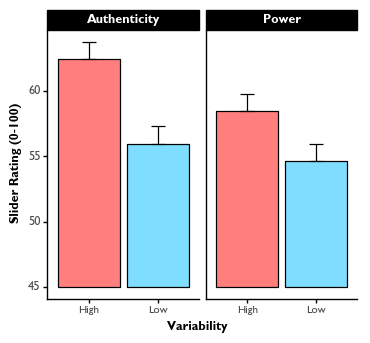

<ggplot: (182942363361)>

In [266]:
# Use plotnine package to plot using ggplot2 (R) style ...
# Manually recoding y-axis labels using 'slider_mean_45' variable (starting y-axis at zero doesn't look good):
(ggplot(plotData, aes(x='factor(variability)', y='slider_mean_45', fill='factor(variability)')) 
 + geom_errorbar(aes(ymax='slider_mean_45 + slider_sem', ymin='slider_mean_45'), position=position_dodge(width=0.9), width=0.2, color='black')
 + geom_bar(stat='identity', position=position_dodge(width=0.9), alpha=0.5, color='black')
 + scale_fill_manual(values=['red', 'deepskyblue'], guide=False)
 + facet_wrap('~ rating_type', nrow=1)
 + scale_y_continuous(labels=['45', '50', '55', '60'])
 + labs(x='Variability', y='Slider Rating (0-100)')
 + theme_classic()
 + theme(figure_size = (4, 3.5),
         text = element_text(family='Gill Sans MT'),
         axis_text_x = element_text(size = 8),
         axis_title_x = element_text(size = 9, weight = 'bold'),
         axis_text_y = element_text(size = 9),
         axis_title_y = element_text(size = 9, weight = 'bold'),
         axis_line_x = element_line(color = 'black'),
         axis_line_y = element_line(color = 'black'),
         strip_text_x = element_text(weight = 'bold', color = 'white', size = 9), 
         strip_background = element_rect(fill = 'black')))

In [267]:
# Run some mediation analyses to examine whether the effect of variability on power/authenticity 
# was mediated by our leadership indices of activation/disinhibition:
#    - IV = variability (0=low; 1=high)
#    - DVs = power/authenticity (in separate models)
#    - MED = leadership ratings
#    - MOD = activation/disinhibition index for rating

modMedData = (cleanRatings_wide
              .drop(['model_id', 'response_authoritative', 'response_openminded', 'response_takeaction',
                    'response_thinkquick', 'response_truefeelings', 'response_truethoughts'], axis=1)
              .rename(index=str, columns={
                  'response_authenticity': 'authenticity',
                  'response_power': 'power',
                  'index_inhibition': 'inhibition',
                  'index_activation': 'activation'
              }))

# 0 = low variability; 1 = high variability
modMedData['model_var'] = 0
modMedData.loc[modMedData['model_block']=='hv', ['model_var']] = 1
modMedData = modMedData.drop(['model_block'], axis=1)

# Convert activation/inhibition indices to long format for mediation:
modMedData = pd.melt(modMedData, id_vars=['subject', 'authenticity', 'power', 'model_var'], 
                     value_vars=['inhibition', 'activation'],
                     var_name='index',
                     value_name='rating')

# 0 = activation; 1 = inhibition
modMedData['index_code'] = 0
modMedData.loc[modMedData['index']=='inhibition', ['index_code']] = 1
modMedData = (modMedData
              .drop(['index'], axis=1)
              .groupby(['subject', 'model_var', 'index_code'])
              .agg({
                  'authenticity': np.mean,
                  'power': np.mean,
                  'rating': np.mean})
              .reset_index())

modMedData

,subject,model_var,index_code,authenticity,power,rating
0,48008,0,0,62.333333,56.500000,55.388889
1,48008,0,1,62.333333,56.500000,56.722222
2,48008,1,0,72.833333,47.333333,44.888889
3,48008,1,1,72.833333,47.333333,57.111111
4,2265064,0,0,74.000000,56.333333,55.833333
5,2265064,0,1,74.000000,56.333333,62.666667
6,2265064,1,0,26.666667,40.333333,45.055556
7,2265064,1,1,26.666667,40.333333,42.166667
8,5889681,0,0,62.500000,49.000000,51.222222
9,5889681,0,1,62.500000,49.000000,50.277778


In [268]:
# Run mediation models (number bootstrapped samples = 1000 per test) ...

# MEDATION 1:  DV = authenticity, MOD = index_code 0 (activation):
medFit_1 = sm.OLS.from_formula('rating ~ model_var', data=modMedData.loc[modMedData['index_code']==0])
outFit_1 = sm.OLS.from_formula('authenticity ~ rating + model_var', data=modMedData.loc[modMedData['index_code']==0])
medTest_1 = smm.Mediation(outFit_1, medFit_1, 'model_var', 'rating').fit(n_rep=1000).summary()

# MEDATION 2:  DV = authenticity, MOD = index_code 1 (inhibition):
medFit_2 = sm.OLS.from_formula('rating ~ model_var', data=modMedData.loc[modMedData['index_code']==1])
outFit_2 = sm.OLS.from_formula('authenticity ~ rating + model_var', data=modMedData.loc[modMedData['index_code']==1])
medTest_2 = smm.Mediation(outFit_2, medFit_2, 'model_var', 'rating').fit(n_rep=1000).summary()

# MEDATION 3:  DV = power, MOD = index_code 0 (activation):
medFit_3 = sm.OLS.from_formula('rating ~ model_var', data=modMedData.loc[modMedData['index_code']==0])
outFit_3 = sm.OLS.from_formula('power ~ rating + model_var', data=modMedData.loc[modMedData['index_code']==0])
medTest_3 = smm.Mediation(outFit_3, medFit_3, 'model_var', 'rating').fit(n_rep=1000).summary()

# MEDATION 4:  DV = power, MOD = index_code 1 (inhibition):
medFit_4 = sm.OLS.from_formula('rating ~ model_var', data=modMedData.loc[modMedData['index_code']==1])
outFit_4 = sm.OLS.from_formula('power ~ rating + model_var', data=modMedData.loc[modMedData['index_code']==1])
medTest_4 = smm.Mediation(outFit_4, medFit_4, 'model_var', 'rating').fit(n_rep=1000).summary()

C:\Users\carr3\Anaconda3\lib\site-packages\patsy\util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
C:\Users\carr3\Anaconda3\lib\site-packages\patsy\util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):


In [269]:
# With activation as mediator to authenticity (DV), average causal mediation effect (ACME)
# is estimated around 2.3 [95% CI: 0.7, 3.9] ...
medTest_1

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),2.313390,0.732057,3.924954,0.008
ACME (treated),2.313390,0.732057,3.924954,0.008
ADE (control),4.095518,1.783714,6.134034,0.000
ADE (treated),4.095518,1.783714,6.134034,0.000
Total effect,6.408908,3.615538,8.974276,0.000
Prop. mediated (control),0.353419,0.155246,0.593576,0.008
Prop. mediated (treated),0.353419,0.155246,0.593576,0.008
ACME (average),2.313390,0.732057,3.924954,0.008
ADE (average),4.095518,1.783714,6.134034,0.000
Prop. mediated (average),0.353419,0.155246,0.593576,0.008


In [270]:
# When mediator is changed to inhibition (with DV=authenticity), ACME effect
# gets stronger = 4.7 [2.8, 6.8] ...
medTest_2

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),4.707634,2.761188,6.798653,0.000
ACME (treated),4.707634,2.761188,6.798653,0.000
ADE (control),1.676370,-0.301651,3.770527,0.114
ADE (treated),1.676370,-0.301651,3.770527,0.114
Total effect,6.384004,3.764467,9.170397,0.000
Prop. mediated (control),0.736395,0.489797,1.072033,0.000
Prop. mediated (treated),0.736395,0.489797,1.072033,0.000
ACME (average),4.707634,2.761188,6.798653,0.000
ADE (average),1.676370,-0.301651,3.770527,0.114
Prop. mediated (average),0.736395,0.489797,1.072033,0.000


In [271]:
# When DV is changed to power, the reverse happens:  Activation has a stronger
# ACME (3.2 [1.0, 5.4]) than inhibition (3.0 [1.8, 4.5]) ...
medTest_3

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),3.201206,0.907754,5.368760,0.008
ACME (treated),3.201206,0.907754,5.368760,0.008
ADE (control),0.362525,-1.107037,1.800090,0.588
ADE (treated),0.362525,-1.107037,1.800090,0.588
Total effect,3.563731,0.924096,6.117682,0.006
Prop. mediated (control),0.897827,0.487617,1.621150,0.006
Prop. mediated (treated),0.897827,0.487617,1.621150,0.006
ACME (average),3.201206,0.907754,5.368760,0.008
ADE (average),0.362525,-1.107037,1.800090,0.588
Prop. mediated (average),0.897827,0.487617,1.621150,0.006


In [272]:
medTest_4

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),3.041678,1.766339,4.467569,0.000
ACME (treated),3.041678,1.766339,4.467569,0.000
ADE (control),0.571149,-1.780008,2.718927,0.620
ADE (treated),0.571149,-1.780008,2.718927,0.620
Total effect,3.612827,1.076665,6.127839,0.004
Prop. mediated (control),0.823233,0.487837,2.456184,0.004
Prop. mediated (treated),0.823233,0.487837,2.456184,0.004
ACME (average),3.041678,1.766339,4.467569,0.000
ADE (average),0.571149,-1.780008,2.718927,0.620
Prop. mediated (average),0.823233,0.487837,2.456184,0.004
